In [4]:
import os 
import IO
from dff_helper import process_dff_trials
from pathlib import Path


#from .roi_stage import run_roi_stage
from utils import group_trials_by_stimulus

In [5]:
%run motion.py

In [6]:
try:
    import tifffile as tiff
except Exception as e:
    raise ImportError("Please install 'tifffile' (pip install tifffile).") 



In [7]:
def load_tiff_stack(path: str | Path) -> np.ndarray:
    """Load a multi-page TIFF as (T, H, W)."""
    arr = tiff.imread(str(path))
    if arr.ndim == 2:
        arr = arr[None, ...]
    if arr.ndim != 3:
        raise ValueError(f"Expected 2D or 3D TIFF; got shape={arr.shape}")
    return arr

In [12]:
from pathlib import Path
import numpy as np

# --------------------------------------------------
# INPUT PATHS
# --------------------------------------------------

path_raw = Path(
    r"Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\raw\JPCM-08699\250911_leica\22_42_interleaved\250911_112136"
)
path_processed = Path(
    r"Z:\Individual_Folders\Tobi\WF_axonimaging\axonal_imaging_tobi\data\processed\JPCM-08699\250911_leica\22_42_interleaved\250911_112136"
)
raw_movie_path = path_raw / "recording.tiff"          # or raw movie .npy
       # or raw movie 
output_dir = path_processed / "masked_data"

# --------------------------------------------------
# LOAD MOVIE
# --------------------------------------------------
movie = load_tiff_stack(raw_movie_path)   # shape: (T, H, W)
#movie = np.load(raw_movie_path)   # shape: (T, H, W)

In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter, binary_fill_holes
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import label


In [20]:
def apply_mask_to_movie(movie: np.ndarray, mask: np.ndarray):
    """
    Apply brain mask without breaking motion correction.

    Masked pixels are set to the median of unmasked pixels.
    """
    masked_movie = movie.copy()
    fill_value = np.median(movie[:, mask])

    masked_movie[:, ~mask] = fill_value
    return masked_movie


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_erosion


def show_mean_image_with_mask_outline(
    movie: np.ndarray,
    mask: np.ndarray,
    cmap: str = "gray",
    color: str = "red",
    linewidth: float = 1.5,
):
    mean_img = movie.mean(axis=0)
    outline = mask ^ binary_erosion(mask)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(mean_img, cmap=cmap)
    ax.contour(outline, levels=[0.5], colors=color, linewidths=linewidth)
    ax.set_title("Mean image with brain mask outline")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


In [73]:
import numpy as np
from scipy.ndimage import binary_fill_holes
from skimage.measure import label
from skimage.morphology import (
    disk,
    binary_erosion,
    binary_opening,
    binary_closing,
)


def compute_brain_mask_simple(
    movie: np.ndarray,
    thr_val: float,
    offset: int = 0,
    smooth_radius: int = 2,
):
    """
    Simple brain mask with smooth outline and inward offset.

    Parameters
    ----------
    movie : np.ndarray
        Raw movie (T, H, W)
    thr_val : float
        Threshold in normalized units (e.g. 0.1)
    offset : int
        Number of pixels to shrink the mask inward
    smooth_radius : int
        Radius (px) for outline smoothing

    Returns
    -------
    mask : np.ndarray (bool)
        Brain mask
    """

    # -------------------------
    # Mean + normalization
    # -------------------------
    mean_img = movie.mean(axis=0)

    vmin = mean_img.min()
    vmax = mean_img.max()

    if vmax > vmin:
        mean_norm = (mean_img - vmin) / (vmax - vmin)
    else:
        mean_norm = np.zeros_like(mean_img)

    # -------------------------
    # Threshold
    # -------------------------
    mask = mean_norm > thr_val

    # -------------------------
    # Fill + connectivity
    # -------------------------
    mask = binary_fill_holes(mask)

    lbl = label(mask)
    if lbl.max() > 1:
        areas = np.bincount(lbl.ravel())
        areas[0] = 0
        mask = lbl == areas.argmax()

    # -------------------------
    # Smooth outline
    # -------------------------
    if smooth_radius > 0:
        selem = disk(smooth_radius)
        mask = binary_opening(mask, selem)
        mask = binary_closing(mask, selem)

    # -------------------------
    # Inward offset (shrink)
    # -------------------------
    if offset > 0:
        selem = disk(offset)
        mask = binary_erosion(mask, selem)

    return mask


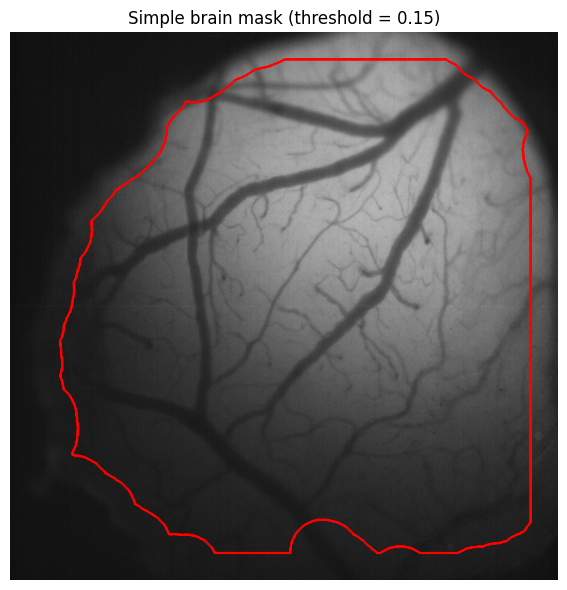

In [81]:
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
thr_val = .15
mask = compute_brain_mask_simple(
    movie,
    thr_val=0.1,
    smooth_radius=10,
    offset=50,
)

outline = mask ^ binary_erosion(mask)

plt.figure(figsize=(6, 6))
plt.imshow(movie.mean(axis=0), cmap="gray")
plt.contour(outline, levels=[0.9], colors="red", linewidths=1.5)
plt.title(f"Simple brain mask (threshold = {thr_val})")
plt.axis("off")
plt.tight_layout()
plt.show()


In [84]:
def save_mask_diagnostic(
    mean_img: np.ndarray,
    mask: np.ndarray,
    out_path: Path,
    cmap: str = "gray",
    color: str = "red",
    linewidth: float = 1.5,
):
    """
    Save a diagnostic plot with mask contours overlaid.
    """
    outline = mask ^ binary_erosion(mask)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(mean_img, cmap=cmap)
    ax.contour(outline, levels=[0.5], colors=color, linewidths=linewidth)
    ax.set_title("Mean image with brain mask outline")
    ax.axis("off")
    plt.tight_layout()

    #fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show(fig)

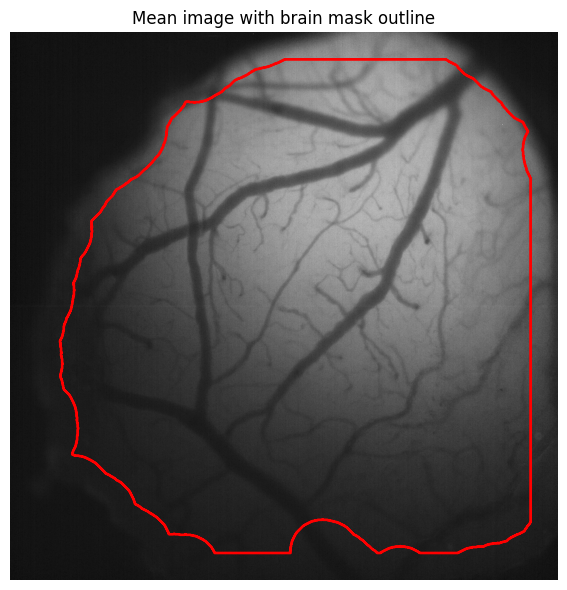

In [85]:
save_mask_diagnostic(movie.mean(axis=0),
                    mask,
                    os.getcwd())